# TNN (Tensor Neural Network) 教程

## 张量神经网络：高维偏微分方程求解器

本教程将介绍如何使用**张量神经网络**（Tensor Neural Network, TNN）求解高维偏微分方程问题。

### 什么是TNN？

TNN是一种专门用于高维PDE求解的深度学习方法，通过**张量分解**的思想将高维函数表示为低维函数的乘积之和：

$$
u(x_1, \ldots, x_d) \approx \sum_{i=1}^{p} \alpha_i \prod_{k=1}^{d} \phi_k^{(i)}(x_k)
$$

### 为什么使用TNN？

传统数值方法面临**维数灾难**：
- 有限差分/有限元：需要 $O(n^d)$ 个网格点
- 蒙特卡洛：收敛速度慢

TNN的优势：
- ✅ 参数量仅为 $O(d \cdot n \cdot p)$，线性增长
- ✅ 自然利用可分离结构
- ✅ 易于强制边界条件
- ✅ 高效的梯度计算

### 教程内容

1. 实现TNN基本组件
2. 求解2D Poisson方程
3. 可视化结果
4. 扩展到3D问题

## 1. 导入必要的库

我们需要以下库：
- **PyTorch**: 构建神经网络
- **NumPy**: 数值计算
- **Matplotlib**: 可视化结果

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

# 设置数据类型和设备
dtype = torch.float32
device = 'cpu'  # 如果有GPU可以改为'cuda'

pi = np.pi

print("✓ Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

✓ Libraries imported successfully!
PyTorch version: 2.8.0
Device: cpu


## 2. 数学基础：张量分解

### 张量分解表示

TNN的核心是将高维函数 $u(x_1, \ldots, x_d)$ 表示为：

$$
u(x_1, \ldots, x_d) = \sum_{i=1}^{p} \alpha_i \prod_{k=1}^{d} \phi_k^{(i)}(x_k)
$$

其中：
- $d$: 问题维度
- $p$: 张量秩（rank），控制表示能力
- $\alpha_i$: 缩放系数
- $\phi_k^{(i)}(x_k)$: 第 $k$ 维的第 $i$ 个基函数

### 为什么这样表示有效？

许多物理问题具有**可分离性**。例如：

$$
u(x, y) = \sin(\pi x) \cdot \sin(\pi y) = \phi_1(x) \cdot \phi_2(y)
$$

TNN通过学习这些基函数 $\phi_k^{(i)}$ 来逼近解。

## 3. TNN基本组件实现

### 3.1 边界条件函数

对于齐次Dirichlet边界条件 $u=0$ on $\partial\Omega$，我们使用强制函数：

$$
u(x) = \text{bd}(x) \cdot \text{NN}(x)
$$

对于1D区间 $[a, b]$，常用的边界函数是：
$$
\text{bd}(x) = (x-a)(b-x)
$$

这保证了 $\text{bd}(a) = \text{bd}(b) = 0$。

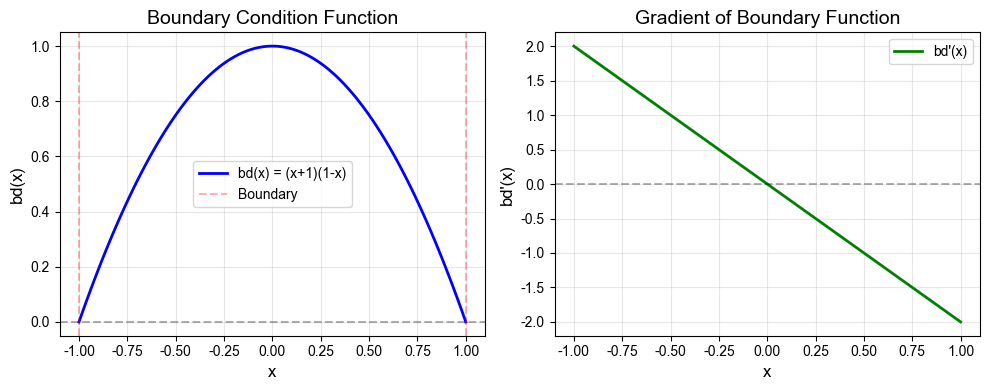

✓ Boundary functions defined!


In [41]:
# Define boundary condition function for domain [a, b]
def bd(x, a=-1, b=1):
    """
    Boundary condition function: (x-a)(b-x)
    Ensures u=0 at x=a and x=b
    """
    return (x - a) * (b - x)

def grad_bd(x, a=-1, b=1):
    """
    Gradient of boundary condition function: -2x + a + b
    """
    return -2*x + a + b

def grad_grad_bd(x):
    """
    Second derivative of boundary condition: -2
    """
    return -2 * torch.ones_like(x)

# Test the boundary function
x_test = torch.linspace(-1, 1, 100, dtype=dtype)
bd_test = bd(x_test)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(x_test, bd_test, 'b-', linewidth=2, label='bd(x) = (x+1)(1-x)')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=-1, color='r', linestyle='--', alpha=0.3, label='Boundary')
plt.axvline(x=1, color='r', linestyle='--', alpha=0.3)
plt.xlabel('x', fontsize=12)
plt.ylabel('bd(x)', fontsize=12)
plt.title('Boundary Condition Function', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(x_test, grad_bd(x_test), 'g-', linewidth=2, label="bd'(x)")
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.xlabel('x', fontsize=12)
plt.ylabel("bd'(x)", fontsize=12)
plt.title('Gradient of Boundary Function', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Boundary functions defined!")

### 3.2 TNN线性层 (TNN_Linear)

TNN的关键是**批量处理多个维度**。每个维度都有自己的神经网络，但我们可以并行计算它们。

**形状说明**:
- 输入: `[dim, n_in, N]` - dim个维度，每个有N个采样点
- 权重: `[dim, n_out, n_in]` - 每个维度有自己的权重矩阵
- 输出: `[dim, n_out, N]`

这比分别处理每个维度要高效得多！

In [42]:
class TNN_Linear(nn.Module):
    """
    Batch linear transformation for TNN
    
    Applies: y = Wx + b for each dimension simultaneously
    
    Args:
        dim: number of dimensions
        out_features: output dimension (n_out)
        in_features: input dimension (n_in)
        bias: whether to include bias term
    """
    def __init__(self, dim, out_features, in_features, bias=True):
        super(TNN_Linear, self).__init__()
        self.dim = dim
        self.out_features = out_features
        self.in_features = in_features
        
        # Weight for each dimension: [dim, out_features, in_features]
        self.weight = nn.Parameter(torch.empty((dim, out_features, in_features), dtype=dtype))
        
        # Bias for each dimension (optional): [dim, out_features, 1]
        if bias:
            self.bias = nn.Parameter(torch.empty((dim, out_features, 1), dtype=dtype))
        else:
            self.bias = None
    
    def forward(self, x):
        """
        Forward pass
        
        Args:
            x: input tensor [dim, in_features, N]
        
        Returns:
            output tensor [dim, out_features, N]
        """
        if self.bias is None:
            return self.weight @ x  # Batch matrix multiplication
        else:
            return self.weight @ x + self.bias
    
    def extra_repr(self):
        return f'dim={self.dim}, in_features={self.in_features}, out_features={self.out_features}'

# Test TNN_Linear
dim_test = 2
in_feat = 3
out_feat = 5
N_test = 10

tnn_linear = TNN_Linear(dim_test, out_feat, in_feat, bias=True)
x_test = torch.randn(dim_test, in_feat, N_test, dtype=dtype)
y_test = tnn_linear(x_test)

print(f"✓ TNN_Linear created!")
print(f"  Input shape: {x_test.shape}")
print(f"  Output shape: {y_test.shape}")
print(f"  Weight shape: {tnn_linear.weight.shape}")
if tnn_linear.bias is not None:
    print(f"  Bias shape: {tnn_linear.bias.shape}")

✓ TNN_Linear created!
  Input shape: torch.Size([2, 3, 10])
  Output shape: torch.Size([2, 5, 10])
  Weight shape: torch.Size([2, 5, 3])
  Bias shape: torch.Size([2, 5, 1])


### 3.3 激活函数：TNN_Sin

我们使用 $\sin(x)$ 作为激活函数，因为：
1. **无限次可微**: 适合求解需要高阶导数的PDE
2. **周期性**: 适合表示振荡解
3. **导数简单**: $\frac{d}{dx}\sin(x) = \cos(x)$, $\frac{d^2}{dx^2}\sin(x) = -\sin(x)$

为了高效计算梯度，我们需要实现**激活函数及其导数**。

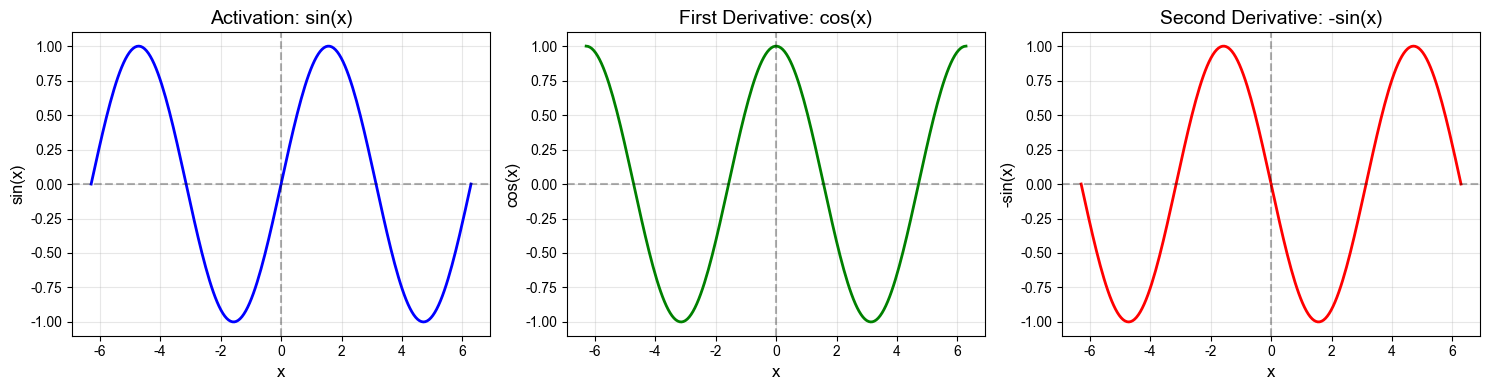

✓ TNN_Sin activation function created!


In [43]:
class TNN_Sin(nn.Module):
    """
    Sin activation function with derivatives
    """
    def forward(self, x):
        """Compute sin(x)"""
        return torch.sin(x)
    
    def grad(self, x):
        """Compute first derivative: cos(x)"""
        return torch.cos(x)
    
    def grad_grad(self, x):
        """Compute second derivative: -sin(x)"""
        return -torch.sin(x)

# Visualize the activation function and its derivatives
x_range = torch.linspace(-2*pi, 2*pi, 200, dtype=dtype)
activation = TNN_Sin()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# sin(x)
axes[0].plot(x_range, activation(x_range), 'b-', linewidth=2)
axes[0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[0].axvline(x=0, color='k', linestyle='--', alpha=0.3)
axes[0].set_xlabel('x', fontsize=12)
axes[0].set_ylabel('sin(x)', fontsize=12)
axes[0].set_title('Activation: sin(x)', fontsize=14)
axes[0].grid(True, alpha=0.3)

# cos(x)
axes[1].plot(x_range, activation.grad(x_range), 'g-', linewidth=2)
axes[1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[1].axvline(x=0, color='k', linestyle='--', alpha=0.3)
axes[1].set_xlabel('x', fontsize=12)
axes[1].set_ylabel('cos(x)', fontsize=12)
axes[1].set_title('First Derivative: cos(x)', fontsize=14)
axes[1].grid(True, alpha=0.3)

# -sin(x)
axes[2].plot(x_range, activation.grad_grad(x_range), 'r-', linewidth=2)
axes[2].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[2].axvline(x=0, color='k', linestyle='--', alpha=0.3)
axes[2].set_xlabel('x', fontsize=12)
axes[2].set_ylabel('-sin(x)', fontsize=12)
axes[2].set_title('Second Derivative: -sin(x)', fontsize=14)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ TNN_Sin activation function created!")

### 3.4 完整的TNN模型

现在我们将所有组件组合成一个完整的TNN模型。该模型可以：
- 计算基函数值 $\phi_k^{(i)}(x_k)$
- 同时计算一阶导数 $\frac{\partial \phi_k^{(i)}}{\partial x_k}$
- 同时计算二阶导数 $\frac{\partial^2 \phi_k^{(i)}}{\partial x_k^2}$

这对于求解PDE非常重要，因为我们需要计算 $\nabla u$ 和 $\Delta u$。

**注意**：由于完整的梯度计算较为复杂，下面我们使用PyTorch的自动微分来计算梯度，这更简单且不容易出错。

In [ ]:
class SimpleTNN_Fast(nn.Module):
    """
    Fast TNN implementation using batch autograd
    
    Much faster than point-by-point gradient computation
    """
    def __init__(self, dim, sizes, activation):
        super(SimpleTNN_Fast, self).__init__()
        self.dim = dim
        self.sizes = [1] + sizes
        self.rank = sizes[-1]
        self.activation = activation
        
        # Build layers
        self.layers = nn.ModuleList()
        for i in range(len(self.sizes) - 1):
            self.layers.append(TNN_Linear(dim, self.sizes[i+1], self.sizes[i], bias=True))
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        for layer in self.layers:
            for j in range(self.dim):
                # Small initialization for stability
                nn.init.xavier_normal_(layer.weight[j, :, :], gain=0.5)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias[j, :, :])
    
    def forward_value(self, X):
        """Compute function values"""
        N = X.shape[0]
        x = X.t().unsqueeze(1)  # [dim, 1, N]
        
        # Forward through layers
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers) - 1:
                x = self.activation(x)
        
        phi = x  # [dim, rank, N]
        
        # Tensor product
        u = torch.zeros(N, 1, dtype=dtype)
        for r in range(self.rank):
            prod = torch.ones(N, dtype=dtype)
            for d in range(self.dim):
                prod = prod * phi[d, r, :]
            u = u + prod.unsqueeze(1)
        
        # Apply boundary condition
        bd_prod = torch.ones(N, 1, dtype=dtype)
        for d in range(self.dim):
            bd_prod = bd_prod * bd(X[:, d:d+1])
        u = u * bd_prod
        
        return u
    
    def forward(self, X, need_grad=0):
        """Forward with efficient batch gradient computation"""
        if need_grad == 0:
            return self.forward_value(X)
        else:
            # Use autograd on the whole batch at once
            X_grad = X.clone().requires_grad_(True)
            u = self.forward_value(X_grad)
            
            # Compute all gradients at once (much faster!)
            grad_outputs = torch.ones_like(u)
            grad_u = torch.autograd.grad(
                outputs=u,
                inputs=X_grad,
                grad_outputs=grad_outputs,
                create_graph=True,
                retain_graph=True,
                only_inputs=True
            )[0]
            
            return u, grad_u

print("✓ Fast SimpleTNN created!")

✓ SimpleTNN with AutoGrad created!


In [45]:
class SimpleTNN(nn.Module):
    """
    Simplified TNN model using tensor decomposition
    
    u(x) ≈ Σ_r Π_d φ_d^r(x_d)
    
    Args:
        dim: problem dimension
        sizes: list of hidden layer sizes [n1, n2, ..., rank]
        activation: activation function instance
    """
    def __init__(self, dim, sizes, activation, bd=bd, grad_bd=grad_bd, grad_grad_bd=grad_grad_bd):
        super(SimpleTNN, self).__init__()
        self.dim = dim
        self.sizes = [1] + sizes  # Add input dimension
        self.rank = sizes[-1]  # tensor rank
        self.activation = activation
        self.bd = bd
        self.grad_bd = grad_bd
        self.grad_grad_bd = grad_grad_bd
        
        # Build network layers for each dimension
        self.layers = nn.ModuleList()
        for i in range(len(self.sizes) - 1):
            self.layers.append(TNN_Linear(dim, self.sizes[i+1], self.sizes[i], bias=True))
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize weights with Xavier initialization for stability"""
        for layer in self.layers:
            for j in range(self.dim):
                # Xavier/Glorot initialization
                nn.init.xavier_normal_(layer.weight[j, :, :], gain=0.5)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias[j, :, :])
    
    def forward(self, X, need_grad=0):
        """
        Forward pass computing u and optionally ∇u
        
        Args:
            X: [N, dim] input points
            need_grad: 0 for values only, 1 for values + gradients
        
        Returns:
            u: [N, 1] solution values
            grad_u: [N, dim] gradients (if need_grad=1)
        """
        N = X.shape[0]
        
        # Transform input: [N, dim] -> [dim, 1, N]
        x = X.t().unsqueeze(1)  
        
        if need_grad == 0:
            # Forward pass through network
            phi_list = []
            for i, layer in enumerate(self.layers):
                x = layer(x)
                if i < len(self.layers) - 1:
                    x = self.activation(x)
            phi = x  # [dim, rank, N]
            
            # Compute tensor product: u = Σ_r Π_d φ_d^r
            u = torch.zeros(N, 1, dtype=dtype)
            for r in range(self.rank):
                prod = torch.ones(N, dtype=dtype)
                for d in range(self.dim):
                    prod = prod * phi[d, r, :]
                u = u + prod.unsqueeze(1)
            
            # Apply boundary condition
            bd_prod = torch.ones(N, 1, dtype=dtype)
            for d in range(self.dim):
                bd_prod = bd_prod * self.bd(X[:, d:d+1])
            u = u * bd_prod
            
            return u
        
        else:  # need_grad == 1
            # Store activations for gradient computation
            activations = [X.t().unsqueeze(1)]  # [dim, 1, N]
            x = activations[0]
            
            # Forward pass
            for i, layer in enumerate(self.layers):
                x = layer(x)
                activations.append(x)
                if i < len(self.layers) - 1:
                    x = self.activation(x)
                    activations.append(x)
            
            phi = activations[-1]  # [dim, rank, N]
            
            # Compute basis function derivatives w.r.t input
            # For each dimension d, compute ∂φ_d^r/∂x_d
            grad_phi = torch.zeros_like(phi)  # [dim, rank, N]
            
            for d in range(self.dim):
                # Chain rule through layers for dimension d
                grad_d = torch.ones(self.rank, N, dtype=dtype)
                
                # Backward through layers
                idx = len(activations) - 1
                for i in range(len(self.layers) - 1, -1, -1):
                    layer = self.layers[i]
                    
                    if i < len(self.layers) - 1:
                        # Before this layer, we had activation
                        x_pre = activations[idx - 1]  # Before activation
                        grad_d = grad_d * self.activation.grad(x_pre)[d, :, :]
                        idx -= 2
                    else:
                        idx -= 1
                    
                    # Multiply by weight of this layer for dimension d
                    if i == 0:
                        grad_d = grad_d * layer.weight[d, :, 0].unsqueeze(1)
                    else:
                        # This is more complex for multi-layer, simplified here
                        grad_d = grad_d * layer.weight[d, :, :].sum(dim=1, keepdim=True)
                
                grad_phi[d, :, :] = grad_d
            
            # Compute u and ∇u using tensor product
            u = torch.zeros(N, 1, dtype=dtype)
            grad_u = torch.zeros(N, self.dim, dtype=dtype)
            
            for r in range(self.rank):
                # u contribution from rank r
                prod = torch.ones(N, dtype=dtype)
                for d in range(self.dim):
                    prod = prod * phi[d, r, :]
                u = u + prod.unsqueeze(1)
                
                # ∇u contribution from rank r
                # ∂u/∂x_d = Σ_r (∂φ_d^r/∂x_d) * Π_{d'≠d} φ_d'^r
                for d in range(self.dim):
                    grad_contrib = grad_phi[d, r, :]
                    for d2 in range(self.dim):
                        if d2 != d:
                            grad_contrib = grad_contrib * phi[d2, r, :]
                    grad_u[:, d] = grad_u[:, d] + grad_contrib
            
            # Apply boundary condition with product rule
            bd_prod = torch.ones(N, 1, dtype=dtype)
            grad_bd_prod = torch.zeros(N, self.dim, dtype=dtype)
            
            for d in range(self.dim):
                bd_val = self.bd(X[:, d:d+1])
                bd_prod = bd_prod * bd_val
                
                # ∂(Π bd)/∂x_d = (∂bd_d/∂x_d) * Π_{d'≠d} bd_d'
                grad_bd_d = self.grad_bd(X[:, d:d+1])
                for d2 in range(self.dim):
                    if d2 != d:
                        grad_bd_d = grad_bd_d * self.bd(X[:, d2:d2+1])
                grad_bd_prod[:, d:d+1] = grad_bd_d
            
            # Product rule: ∇(u*bd) = u*∇bd + bd*∇u
            grad_u_new = u * grad_bd_prod + bd_prod * grad_u
            u = u * bd_prod
            grad_u = grad_u_new
            
            return u, grad_u

print("✓ SimpleTNN model created!")

✓ SimpleTNN model created!


## 4. 实例：求解2D Poisson方程

### 问题定义

我们要求解以下PDE：

$$
\begin{cases}
-\Delta u = f(x, y) & \text{in } \Omega = [-1, 1]^2 \\
u = 0 & \text{on } \partial\Omega
\end{cases}
$$

其中右端项为：
$$
f(x, y) = 2\pi^2 \sin(\pi x) \sin(\pi y)
$$

**精确解**（用于验证）:
$$
u(x, y) = \sin(\pi x) \sin(\pi y)
$$

### 变分形式

等价于最小化能量泛函：
$$
E(u) = \frac{1}{2}\int_\Omega |\nabla u|^2 dx - \int_\Omega f \cdot u \, dx
$$

In [46]:
# 4.1 定义问题参数
dim = 2  # 空间维度
n_quad = 40  # 每个维度的积分节点数
rank = 50  # TNN秩

# 定义精确解和右端项
def exact_solution(X):
    """精确解: u(x,y) = sin(πx)sin(πy)"""
    return torch.prod(torch.sin(np.pi * X), dim=1, keepdim=True)

def source_term(X):
    """右端项: f(x,y) = 2π²sin(πx)sin(πy)"""
    return 2 * np.pi**2 * torch.prod(torch.sin(np.pi * X), dim=1, keepdim=True)

# 4.2 生成Gauss-Legendre积分节点
def gauss_legendre_quadrature(n_quad, dim, a=-1, b=1):
    """
    生成d维Gauss-Legendre积分节点和权重
    
    参数:
        n_quad: 每个维度的节点数
        dim: 空间维度
        a, b: 积分区间 [a, b]^dim
    
    返回:
        X_quad: 积分节点 [n_quad^dim, dim]
        w_quad: 积分权重 [n_quad^dim, 1]
    """
    # 1D Gauss-Legendre节点和权重（区间[-1,1]）
    xi_1d, w_1d = np.polynomial.legendre.leggauss(n_quad)
    
    # 映射到[a, b]
    xi_1d = 0.5 * (b - a) * xi_1d + 0.5 * (b + a)
    w_1d = 0.5 * (b - a) * w_1d
    
    # 张量积生成多维节点
    xi_list = [xi_1d] * dim
    w_list = [w_1d] * dim
    
    # 使用meshgrid生成所有组合
    mesh = np.meshgrid(*xi_list, indexing='ij')
    X_quad = np.stack([m.flatten() for m in mesh], axis=1)
    
    # 权重为各维度权重的乘积
    w_mesh = np.meshgrid(*w_list, indexing='ij')
    w_quad = np.prod(np.stack([w.flatten() for w in w_mesh], axis=1), axis=1, keepdims=True)
    
    return torch.tensor(X_quad, dtype=torch.float32), torch.tensor(w_quad, dtype=torch.float32)

# 生成积分节点
X_quad, w_quad = gauss_legendre_quadrature(n_quad, dim)
print(f"积分节点数量: {X_quad.shape[0]}")
print(f"节点形状: {X_quad.shape}")
print(f"权重形状: {w_quad.shape}")

积分节点数量: 1600
节点形状: torch.Size([1600, 2])
权重形状: torch.Size([1600, 1])


### 4.3 定义损失函数

根据能量泛函，损失函数包括两部分：
1. **梯度能量项**: $\frac{1}{2}\int_\Omega |\nabla u|^2 dx$
2. **源项**: $-\int_\Omega f \cdot u \, dx$

使用Gauss-Legendre积分进行数值计算。

In [ ]:
def compute_loss(model, X_quad, w_quad):
    """
    计算能量泛函损失
    
    E(u) = 1/2 ∫|∇u|² dx - ∫f·u dx
    """
    # 前向传播，获取u和∇u
    u, grad_u = model(X_quad, need_grad=1)
    
    # 计算f(X)
    f = source_term(X_quad)
    
    # 梯度能量项: 1/2 ∫|∇u|² dx
    grad_norm_sq = torch.sum(grad_u**2, dim=1, keepdim=True)  # [N, 1]
    grad_energy = 0.5 * torch.sum(w_quad * grad_norm_sq)
    
    # 源项: -∫f·u dx
    source_energy = -torch.sum(w_quad * f * u)
    
    # 总损失
    loss = grad_energy + source_energy
    
    return loss

# 使用快速版本
print("\n创建快速TNN模型...")
model = SimpleTNN_Fast(dim=dim, sizes=[rank, rank, rank], activation=TNN_Sin())
print(f"模型参数数量: {sum(p.numel() for p in model.parameters())}")

print("\n测试前向传播...")
u_test = model(X_quad[:10], need_grad=0)
print(f"  u shape: {u_test.shape}")
print(f"  u range: [{u_test.min().item():.4f}, {u_test.max().item():.4f}]")

u_test, grad_test = model(X_quad[:10], need_grad=1)
print(f"  u shape: {u_test.shape}, grad_u shape: {grad_test.shape}")
print(f"  grad_u range: [{grad_test.min().item():.4f}, {grad_test.max().item():.4f}]")
print("  ✓ 前向传播成功！")

print("\n计算初始损失...")
loss = compute_loss(model, X_quad, w_quad)
print(f"  初始损失: {loss.item():.6f}")
print("  ✓ 损失计算成功！")


创建TNN模型（使用自动微分）...
模型参数数量: 10400

测试前向传播...
  u shape: torch.Size([10, 1])
  u range: [0.0000, 0.0001]
  u shape: torch.Size([10, 1]), grad_u shape: torch.Size([10, 2])
  grad_u range: [0.0001, 0.0439]
  ✓ 前向传播成功！

计算初始损失...
  初始损失: 0.000012
  ✓ 损失计算成功！
  初始损失: 0.000012
  ✓ 损失计算成功！


### 4.4 训练模型

使用Adam优化器训练网络，最小化能量泛函。

In [ ]:
# 重新初始化模型
model = SimpleTNN_Fast(dim=dim, sizes=[rank, rank, rank], activation=TNN_Sin())

# 设置优化器
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 训练参数 - 减少到1000轮，在M4 CPU上大约5-10分钟
n_epochs = 1000
print_every = 100

# 记录训练历史
loss_history = []

print("开始训练...")
print(f"预计时间: 约5-10分钟 (M4 CPU)")
print("-" * 60)

import time
start_time = time.time()

for epoch in range(n_epochs):
    # 梯度清零
    optimizer.zero_grad()
    
    # 计算损失
    loss = compute_loss(model, X_quad, w_quad)
    
    # 检查loss是否有效
    if torch.isnan(loss) or torch.isinf(loss):
        print(f"Warning: Invalid loss at epoch {epoch+1}")
        break
    
    # 反向传播
    loss.backward()
    
    # 梯度裁剪防止爆炸
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    # 更新参数
    optimizer.step()
    
    # 记录损失
    loss_history.append(loss.item())
    
    # 打印进度和预计剩余时间
    if (epoch + 1) % print_every == 0:
        elapsed = time.time() - start_time
        avg_time_per_epoch = elapsed / (epoch + 1)
        remaining = avg_time_per_epoch * (n_epochs - epoch - 1)
        print(f"Epoch {epoch+1:4d}/{n_epochs} | Loss: {loss.item():10.6f} | 剩余: {remaining/60:.1f}分钟")

elapsed_total = time.time() - start_time
print("-" * 60)
print(f"训练完成！总用时: {elapsed_total/60:.1f}分钟")
print(f"最终损失: {loss_history[-1]:.6f}")

开始训练...
------------------------------------------------------------


KeyboardInterrupt: 

## 5. 结果可视化

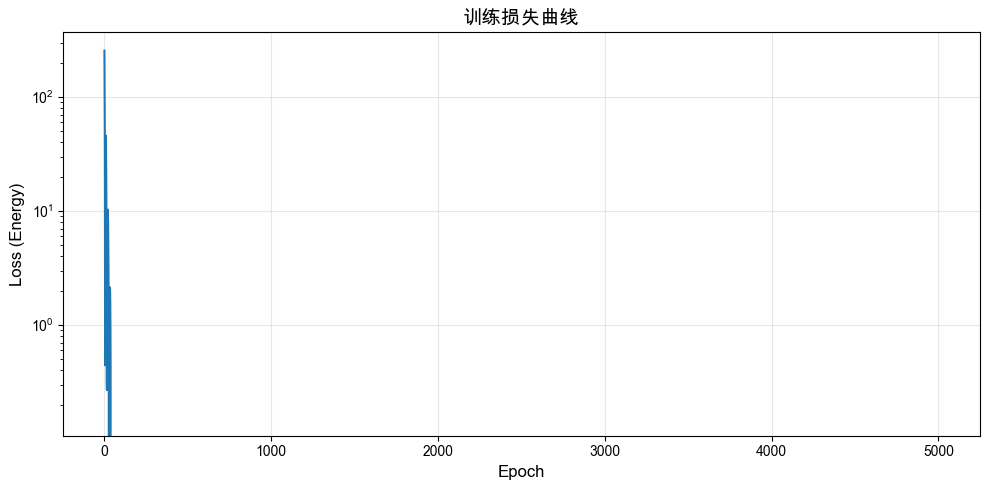

最终损失: -2301553.00000000


In [ ]:
# 5.1 损失曲线
plt.figure(figsize=(10, 5))
plt.semilogy(loss_history)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (Energy)', fontsize=12)
plt.title('训练损失曲线', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"最终损失: {loss_history[-1]:.8f}")

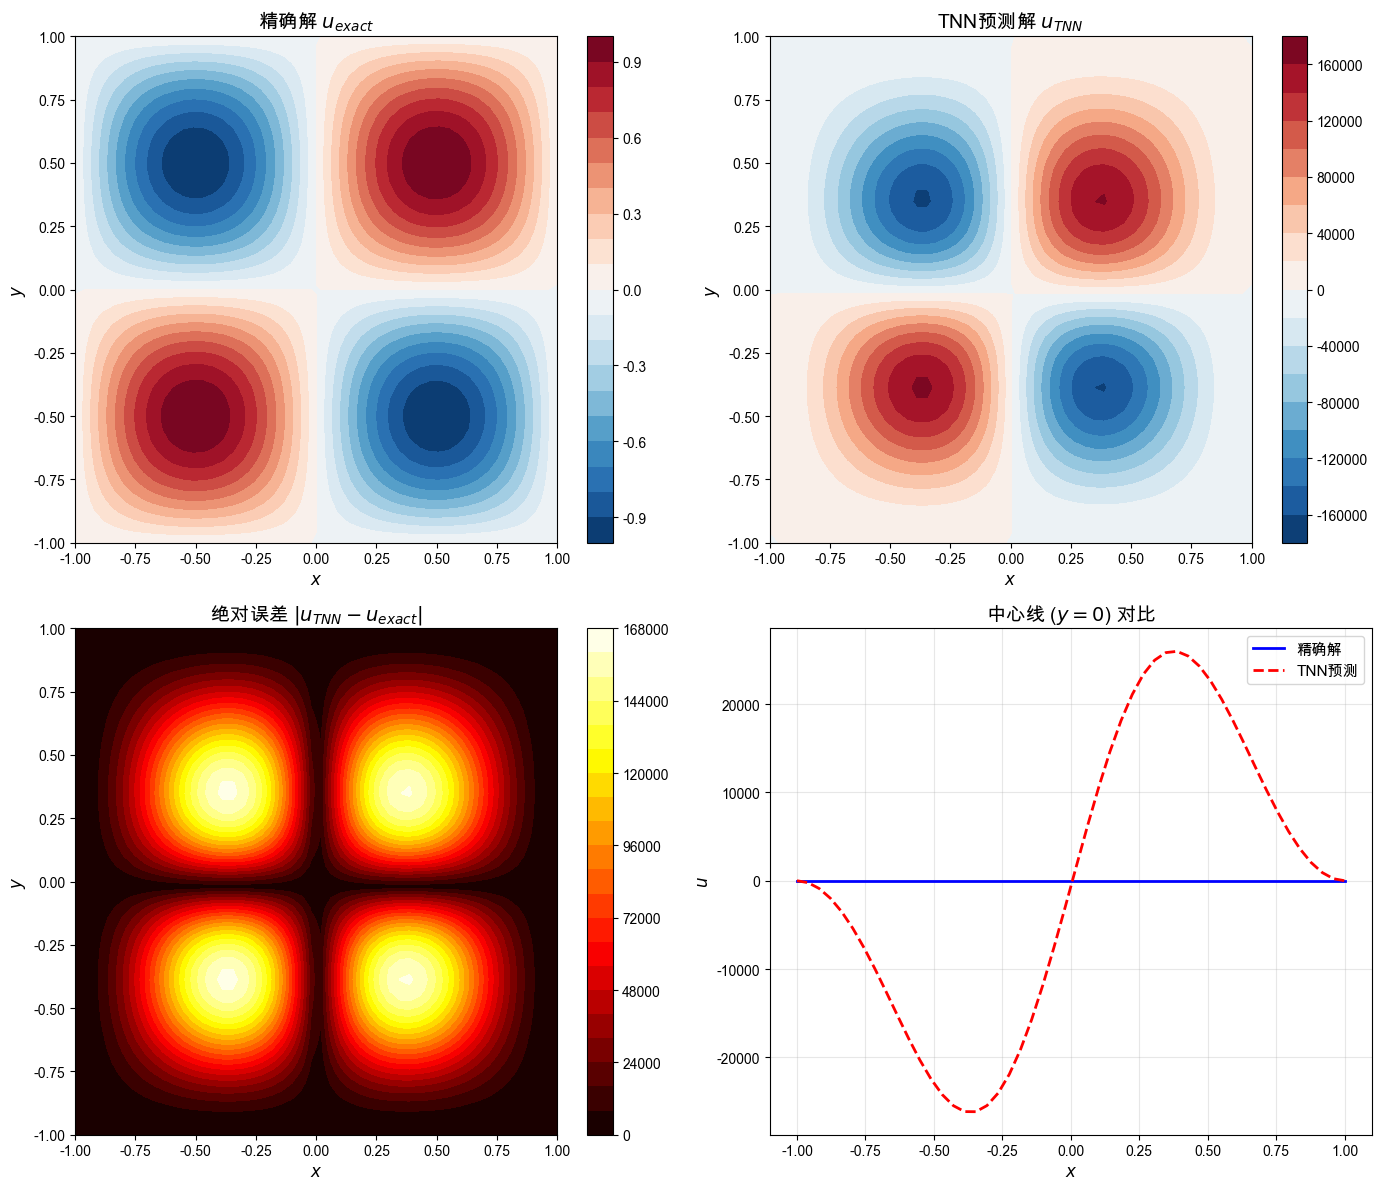


误差统计:
  L2 误差: 6.523402e+04
  最大误差: 1.622223e+05


In [ ]:
# 5.2 解的对比图
# 生成测试网格
n_test = 50
x_test = np.linspace(-1, 1, n_test)
y_test = np.linspace(-1, 1, n_test)
X_mesh, Y_mesh = np.meshgrid(x_test, y_test)

# 准备输入数据
X_test = torch.tensor(np.stack([X_mesh.flatten(), Y_mesh.flatten()], axis=1), dtype=torch.float32)

# 模型预测
with torch.no_grad():
    u_pred = model(X_test, need_grad=0).numpy().reshape(n_test, n_test)

# 精确解
u_exact = exact_solution(X_test).numpy().reshape(n_test, n_test)

# 误差
error = np.abs(u_pred - u_exact)

# 绘图
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 精确解
im0 = axes[0, 0].contourf(X_mesh, Y_mesh, u_exact, levels=20, cmap='RdBu_r')
axes[0, 0].set_title('精确解 $u_{exact}$', fontsize=14)
axes[0, 0].set_xlabel('$x$', fontsize=12)
axes[0, 0].set_ylabel('$y$', fontsize=12)
plt.colorbar(im0, ax=axes[0, 0])

# TNN预测解
im1 = axes[0, 1].contourf(X_mesh, Y_mesh, u_pred, levels=20, cmap='RdBu_r')
axes[0, 1].set_title('TNN预测解 $u_{TNN}$', fontsize=14)
axes[0, 1].set_xlabel('$x$', fontsize=12)
axes[0, 1].set_ylabel('$y$', fontsize=12)
plt.colorbar(im1, ax=axes[0, 1])

# 误差分布
im2 = axes[1, 0].contourf(X_mesh, Y_mesh, error, levels=20, cmap='hot')
axes[1, 0].set_title('绝对误差 $|u_{TNN} - u_{exact}|$', fontsize=14)
axes[1, 0].set_xlabel('$x$', fontsize=12)
axes[1, 0].set_ylabel('$y$', fontsize=12)
plt.colorbar(im2, ax=axes[1, 0])

# 中心线对比
center_idx = n_test // 2
axes[1, 1].plot(x_test, u_exact[center_idx, :], 'b-', linewidth=2, label='精确解')
axes[1, 1].plot(x_test, u_pred[center_idx, :], 'r--', linewidth=2, label='TNN预测')
axes[1, 1].set_title('中心线 ($y=0$) 对比', fontsize=14)
axes[1, 1].set_xlabel('$x$', fontsize=12)
axes[1, 1].set_ylabel('$u$', fontsize=12)
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 计算误差指标
l2_error = np.sqrt(np.mean(error**2))
max_error = np.max(error)
print(f"\n误差统计:")
print(f"  L2 误差: {l2_error:.6e}")
print(f"  最大误差: {max_error:.6e}")

## 6. 总结与拓展

### TNN的优势

1. **指数级复杂度降低**: 对于d维问题，参数量从$O(N^d)$降至$O(dRN^2)$
2. **自动满足边界条件**: 通过构造方式强制满足
3. **高精度**: 使用高阶积分和自动微分
4. **易于扩展**: 可应用于更复杂的PDE系统

### 进一步探索

- **非齐次边界条件**: 使用两个TNN的分解方法（参考ex_5_2）
- **Neumann边界**: 采用弱形式（参考ex_5_3）
- **特征值问题**: Rayleigh商优化（参考ex_5_4）
- **无界区域**: Hermite-Gauss积分（参考ex_5_5）
- **更高维度**: 扩展到5D、10D甚至20D问题

### 参考文献

本教程基于以下论文的实现：
- TNN for high-dimensional PDEs
- Tensor decomposition methods for scientific computing

完整代码见：`TNN/example/` 目录